<a href="https://colab.research.google.com/github/barbaroja2000/imagery/blob/main/Deep_Floyd_IF_Text_Generation_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Floyd IF - Text Generation Experiments

* Runs on google free tier (T4) via cpu offloading
* It is ... slow - (6-8 minutes e2e generation). Down to CPU offloading & pipe deletion, If your running on a decent GPU you should comment this out
* Deep Floyd requires model signup/T&C . Requires API token in HF call
* Model card https://huggingface.co/DeepFloyd/IF-I-XL-v1.0
* Instructions on running on low GPU memory -  https://huggingface.co/docs/diffusers/main/en/api/pipelines/if
* Other ref:
  * https://github.com/deep-floyd/IF
  * https://www.deepfloyd.ai/deepfloyd-if
  * https://stablediffusionweb.com/prompts

## Observations
* Repeat the text you want to print multiple times in the prompt for best results

In [1]:
!pip install -qU diffusers accelerate transformers safetensors sentencepiece accelerate bitsandbytes

<table>
<tr><td>
<img src="https://i.imgur.com/5r76h7q.png" title="source: imgur.com" /></td><td>
<a href="https://imgur.com/SrgJjSU"><img src="https://i.imgur.com/SrgJjSU.png" title="source: imgur.com" /></a></td>
<td><img src="https://i.imgur.com/1dKZzK5.png" title="source: imgur.com" /></td>
</tr>
<tr>
<td><img src="https://i.imgur.com/MBTqrqd.png" title="source: imgur.com" /></td>
<td>&nbsp;</td>
<td>&nbsp;</td>
</tr>


</table>


In [2]:
#@title Load Keys
#@markdown Utitily to load keys from fs, replace with environ vars if not using
!python -m pip install python-dotenv
import os

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
import dotenv
dotenv.load_dotenv('/content/drive/MyDrive/keys/keys.env')

Mounted at /content/drive/


True

In [3]:
HUGGINGFACEHUB_API_TOKEN=os.environ.get("HUGGINGFACEHUB_API_TOKEN")

In [4]:
#@title Imports
from diffusers import IFPipeline, IFSuperResolutionPipeline,DiffusionPipeline
import torch
import gc
from transformers import T5EncoderModel
from diffusers.utils import pt_to_pil
import matplotlib.pyplot as plt
from PIL import Image

In [28]:
NEGATIVE_PROMPT="""(((cropping))), (((cropped))), blurry, watermark, watermarked, worst quality, low quality, jpeg artifacts, poorly lit, glitch, error, out of focus (((truncated text)))"""

* 10,000 BC
* Wildstyle
* Roamin Romans
* Paddy time
* Golden Nuggets
* Treasure Tsunami
* Tiki Tiki

GPT4 Prompt to generate text-to-image prompt:

you are an expert prompt writer writing a prompt for a text-to-image generator that generates  text in image. the prompt should be descriptive of the style, colour, and mood that you want to display. specifiy that the background should be black. repeating the text to display seems to work well.

here is an example where its worked well.

Hawaii style text "Tiki Tiki" on a black background. Halau style font graphic woodcut embossed sticker. Three colours only moody. text "Tiki Tiki"

I will provide you some text to generate.  do you understand?

In [7]:
prompt = 'vector drawing cartoon graffiti style  text "Paddy time"  on a black background with no texture.  pub design, pro vector, irish style, full design, 6 colors only, solid colors, no shadows, full design, warm colors, sticker with text "Paddy time", bright colors'
#prompt='aztec style  text "Montezumas Revenge"  on a black background.  pro vector, full design, 6 colors only, solid colors, shadows, hot colors, sticker, bright colors'

In [8]:
prompt = 'wildstyle graffiti  text "TIKI TIKI"  on a black background.  6 colors only, solid colors, no shadows, full design, hot colors, sticker, bright colors   spray paint text "TIKI TIKI" '
#prompt = 'neon sign text "Miami Heat" black background no texture.  photorealistic purple teal blue white pink orange color neon sign "Miami Heat"'

In [9]:
prompt ='Hawaii style text "Tiki Tiki" on a black background. Halau style font graphic woodcut embossed sticker. Three colours only moody. text "Tiki Tiki"'

In [29]:
prompt="""Prehistoric cave painting style text "10,000 BC" on a black background. Rough stone-textured font with text "10,000. BC" primitive hand-drawn motifs. Earthy tones only, evoking an ancient and mystical mood. Text "10,000 BC"  sticker poster inside frame.
"""

In [11]:
#@title Class : Utility methods for displaying generated output + 3 stage pass & embeddings
class DeepFloydIF:
    def __init__(self, huggingfacehub_api_token, negative_prompt):

        if not isinstance(huggingfacehub_api_token, str) or not huggingfacehub_api_token:
            raise ValueError("huggingfacehub_api_token must be a non-empty string.")

        if not isinstance(negative_prompt, str) or not negative_prompt:
            raise ValueError("negative_prompt must be a non-empty string.")

        self.huggingfacehub_api_token = huggingfacehub_api_token
        self.negative_prompt = negative_prompt
        self.generator = torch.Generator().manual_seed(0)

    def _init_pipeline(self, model_name, **kwargs):
        """Initialize a pipeline with the given model name and parameters."""
        kwargs["torch_dtype"] = torch.float16
        kwargs["use_auth_token"] = self.huggingfacehub_api_token
        pipeline = DiffusionPipeline.from_pretrained(model_name, **kwargs)
        pipeline.enable_model_cpu_offload()
        return pipeline

    def _clean_memory(self):
        """Clean up memory."""
        gc.collect()
        torch.cuda.empty_cache()

    def create_embedding(self, prompt):

        if not isinstance(prompt, str) or not prompt:
          raise ValueError("prompt must be a non-empty string.")

        pipe = self._init_pipeline("DeepFloyd/IF-I-XL-v1.0", variant="fp16")
        prompt_embeds, negative_embeds = pipe.encode_prompt(prompt, self.negative_prompt)
        del pipe
        self._clean_memory()
        return prompt_embeds, negative_embeds

    def create_versions(self, prompt_embeds, negative_embeds, num_images_per_prompt):

        if not torch.is_tensor(prompt_embeds) or not torch.is_tensor(negative_embeds):
            raise ValueError("Both prompt_embeds and negative_embeds should be PyTorch tensors.")

        if not isinstance(num_images_per_prompt, int) or num_images_per_prompt <= 0:
            raise ValueError("num_images_per_prompt must be a positive integer.")

        pipe = self._init_pipeline(
            "DeepFloyd/IF-I-XL-v1.0",
            text_encoder=None,
            variant="fp16",
            device_map="auto"
        )
        preview_images = pipe(
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_embeds,
            num_images_per_prompt=num_images_per_prompt,
            generator=self.generator,
            output_type="pt"
        ).images

        del pipe
        self._clean_memory()
        return preview_images

    def display_preview(self, preview_images):

        # Ensure that preview_images is a tensor with the expected dimensionality ([N, C, H, W]).
        if not torch.is_tensor(preview_images) or preview_images.dim() != 4:
            raise ValueError("preview_images should be a 4D PyTorch tensor ([N, C, H, W]).")

        pil_images = pt_to_pil(preview_images)  # Convert the entire 4D tensor to a list of PIL images
        num_images = len(pil_images)
        num_cols = min(num_images, 4)
        num_rows = (num_images - 1) // num_cols + 1

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
        axes = axes.ravel() if num_rows * num_cols > 1 else [axes]

        for idx, pil_image in enumerate(pil_images):
            axes[idx].imshow(pil_image)
            axes[idx].axis('off')
        plt.tight_layout()
        plt.show()

    def super_resolution(self, preview_image, prompt_embeds, negative_embeds):

        # Ensure that preview_image is a PIL image.
        if not isinstance(preview_image, Image.Image):
             raise ValueError("preview_image must be a PIL image.")

        pipe = self._init_pipeline(
            "DeepFloyd/IF-II-L-v1.0",
            text_encoder=None,
            variant="fp16",
            device_map="auto"
        )

        image = pipe(
            image=preview_image,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_embeds,
            output_type="pt",
            generator=self.generator,
        ).images

        del pipe
        self._clean_memory()

        return pt_to_pil(image)[0]

    def final_resolution(self, prompt, image):

        if not isinstance(prompt, str) or not prompt:
            raise ValueError("prompt must be a non-empty string.")

        # Ensure that final_image is a PIL image.
        if not isinstance(image, Image.Image):
             raise ValueError("image must be a PIL image.")

        pipe = self._init_pipeline(
            "stabilityai/stable-diffusion-x4-upscaler"
        )

        final_image = pipe(
            prompt=prompt,
            image=image,
            generator=self.generator,
            noise_level=100
        ).images[0]
        del pipe
        self._clean_memory()

        return final_image

    def print_final(self, final_image):

        # Ensure that final_image is a PIL image.
        if not isinstance(final_image, Image.Image):
             raise ValueError("image must be a PIL image.")

        plt.figure(figsize=(5, 5))
        plt.imshow(final_image)
        plt.axis('off')
        plt.show()

    def final_save(self, final_image, path):

        # Ensure that final_image is a PIL image.
        if not isinstance(final_image, Image.Image):
            raise ValueError("final_image must be a PIL image.")

        # Ensure that path is a valid file path with appropriate suffix.
        if not isinstance(path, str) or not path:
            raise ValueError("path must be a non-empty string.")

        valid_suffixes = [".png", ".jpg", ".jpeg"]
        if not any(path.lower().endswith(suffix) for suffix in valid_suffixes):
            raise ValueError(f"path must end with one of the valid image suffixes: {', '.join(valid_suffixes)}")

        final_image.save(path)

In [23]:
#@title Create an instance of the DeepFloydIF class
deep_floyd = DeepFloydIF(huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN, negative_prompt=NEGATIVE_PROMPT)

In [31]:
#@title Get prompt and negative embeddings
prompt_embeds, negative_embeds = deep_floyd.create_embedding(prompt)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00001-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of T5EncoderModel were not initialized from the model checkpoint at /root/.cache/huggingface/hub/models--DeepFloyd--IF-I-XL-v1.0/snapshots/c03d510e9b75bce9f9db5bb85148c1402ad7e694/text_encoder and are newly initialized: ['encoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
#@title Create preview images
num_images_per_prompt = 18  # Adjust this value as needed
preview_images = deep_floyd.create_versions(prompt_embeds, negative_embeds, num_images_per_prompt)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00001-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

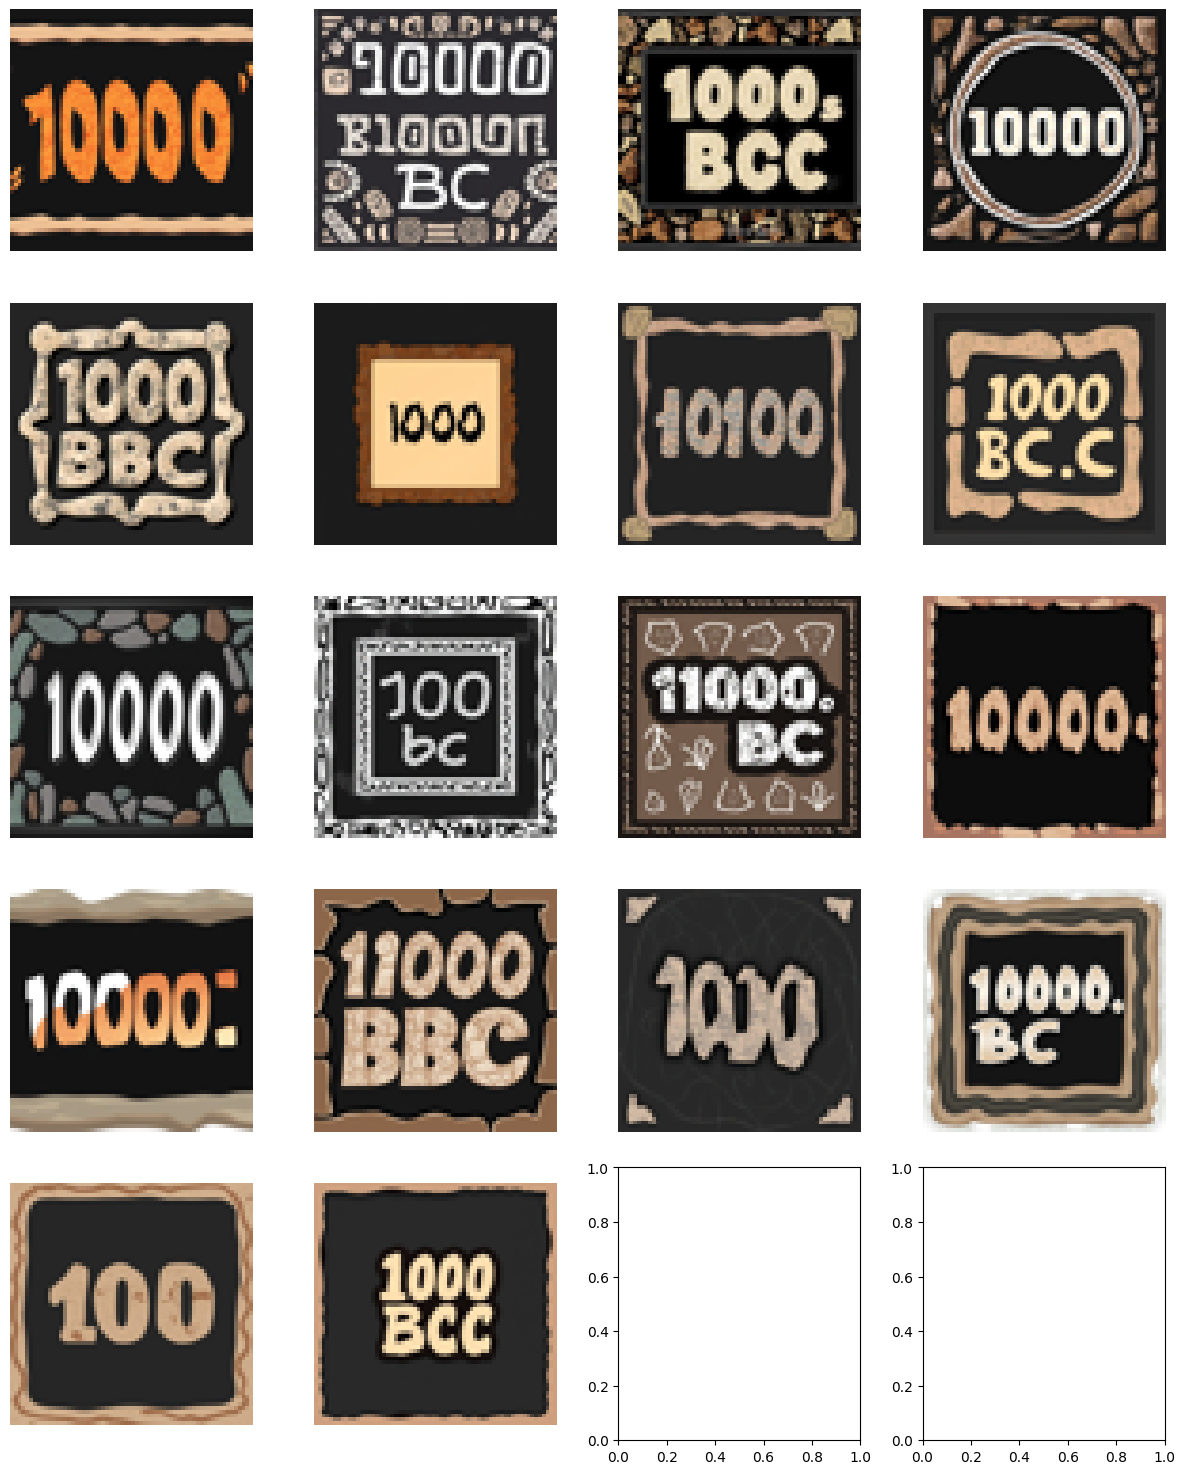

In [33]:
deep_floyd.display_preview(preview_images)


In [38]:
#@title Select preview image  and first stage upscale

preview_image = pt_to_pil(preview_images)[1]
super_res_image = deep_floyd.super_resolution(preview_image, prompt_embeds, negative_embeds)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00001-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

In [39]:
#@title Further refine the resolution
final_image = deep_floyd.final_resolution(prompt, super_res_image)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

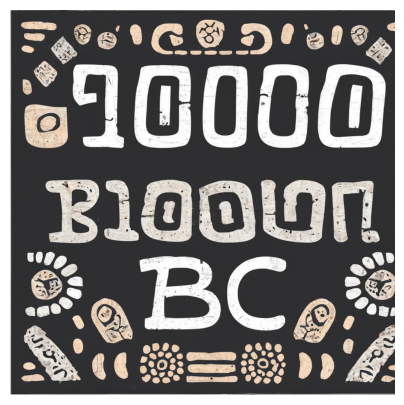

In [40]:
# Print the final image
deep_floyd.print_final(final_image)

#Save
deep_floyd.final_save(final_image, "./wiki.png")